In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import adabound
from sklearn.metrics import accuracy_score, roc_auc_score
torch.cuda.is_available()

True

In [2]:
mydata = pd.read_csv('D:/Cho Lab Dropbox/연구과제별정리/02 목적과제_SPPEC_암종별(임상)_상희회준/위암/03 머신러닝_회준종혁다혜/01 Model/다혜/DL_data_220727.csv')

In [3]:
mydata = mydata[mydata['Age']>74]

In [4]:
event_data = mydata['Early_CC_AnastomoticLeakage']
pd.crosstab(mydata['OP_year'], mydata['Early_CC_AnastomoticLeakage'])

Early_CC_AnastomoticLeakage,0,1
OP_year,,
2014,71,3
2015,62,0
2016,64,1
2017,66,5
2018,51,6
2019,46,6
2020,78,1
2021,53,8


In [5]:
pre_op_dat = mydata[['Sex', 
        'Age',
        'ASA_Score',
        'Smoking',
        'Drinking',
        'BMI',
        'Hypertension',
        'Diabetes',
        'Ass_condition_grp',
        'Ass_lesion',
        'Clinical_Stage_grp ',
        'Histology',
        'Lauren',
        'Reconstruction',
        'Combined_Resection',
        'Platelets',
        'Albumin',
        'Cell_Count',
        'Hemoglobin_status',
        'Neutrophil_count_status'
]]

post_op_dat = mydata[['fStage_grp',
                'Location',
                'LN_Dissection',
                'Operation',
                'Intraop_cc',
                'OP_time',
                'EBL'
                ]]

In [6]:
nsubject = mydata.shape[0]

In [7]:
contvar = ['Age', "Platelets", "Albumin", "Cell_Count"]
catevar= pre_op_dat.columns[[x not in contvar for x in pre_op_dat.columns]]

contvar_post = ['OP_time', 'EBL']
catevar_post = post_op_dat.columns[[x not in contvar_post for x in post_op_dat.columns]]

In [8]:
pre_op_dat2 = pre_op_dat.copy()
pre_op_dat2[catevar] = pre_op_dat2[catevar].astype("category")

post_op_dat2 = post_op_dat.copy()
post_op_dat2[catevar_post] = post_op_dat2[catevar_post].astype("category")

print(pre_op_dat2.dtypes, post_op_dat2.dtypes)

Sex                        category
Age                           int64
ASA_Score                  category
Smoking                    category
Drinking                   category
BMI                        category
Hypertension               category
Diabetes                   category
Ass_condition_grp          category
Ass_lesion                 category
Clinical_Stage_grp         category
Histology                  category
Lauren                     category
Reconstruction             category
Combined_Resection         category
Platelets                     int64
Albumin                     float64
Cell_Count                  float64
Hemoglobin_status          category
Neutrophil_count_status    category
dtype: object fStage_grp       category
Location         category
LN_Dissection    category
Operation        category
Intraop_cc       category
OP_time             int64
EBL               float64
dtype: object


In [9]:
pre_op_dat3 = pd.get_dummies(pre_op_dat2, columns=catevar)
pre_dat = pre_op_dat3.to_numpy()

post_op_dat3 = pd.get_dummies(post_op_dat2, columns=catevar_post)

In [10]:
pre_op_dat3.shape

(521, 45)

In [11]:
pre_op_dat3

,Age,Platelets,Albumin,Cell_Count,Sex_F,Sex_M,ASA_Score_1,ASA_Score_2,Smoking_no,Smoking_yes,...,Reconstruction_1 BI,Reconstruction_2 BII,Reconstruction_3 Roux-en-Y,Reconstruction_4 Others,Combined_Resection_No,Combined_Resection_Yes,Hemoglobin_status_1. Normal,Hemoglobin_status_2. Abnormal,Neutrophil_count_status_1. Normal,Neutrophil_count_status_2. Abnormal
16,76,187,4.5,166.940,0,1,1,0,1,0,...,0,0,0,1,1,0,1,0,1,0
21,80,299,3.8,237.958,1,0,1,0,1,0,...,0,0,1,0,1,0,1,0,1,0
42,76,197,3.8,165.851,0,1,1,0,1,0,...,0,1,0,0,1,0,1,0,1,0
56,75,223,4.8,105.984,1,0,1,0,1,0,...,0,0,0,1,1,0,1,0,1,0
58,79,241,4.8,292.024,0,1,1,0,0,1,...,1,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3500,77,180,4.3,130.277,0,1,1,0,1,0,...,0,1,0,0,1,0,1,0,1,0
3508,82,234,4.3,179.278,1,0,1,0,1,0,...,0,1,0,0,1,0,1,0,1,0
3523,78,128,4.3,167.862,0,1,0,1,1,0,...,1,0,0,0,1,0,1,0,1,0
3525,77,188,4.3,120.124,0,1,0,1,1,0,...,0,1,0,0,1,0,0,1,1,0


In [12]:
pre_op_dat3.isnull().sum()

Age                                                     0
Platelets                                               0
Albumin                                                 0
Cell_Count                                              0
Sex_F                                                   0
Sex_M                                                   0
ASA_Score_1                                             0
ASA_Score_2                                             0
Smoking_no                                              0
Smoking_yes                                             0
Drinking_no                                             0
Drinking_yes                                            0
BMI_1 <18.5                                             0
BMI_2 18.5-24.9                                         0
BMI_3 >25                                               0
Hypertension_no                                         0
Hypertension_yes                                        0
Diabetes_no   

In [13]:
post_op_dat3.isnull().sum()

OP_time                          0
EBL                              0
fStage_grp_1.0                   0
fStage_grp_2.0                   0
Location_1 Lower                 0
Location_2 Middle                0
Location_3 Upper                 0
Location_4 Others                0
LN_Dissection_1. D1              0
LN_Dissection_2. D2              0
Operation_Partial Gastractomy    0
Operation_Total Gastractomy      0
Intraop_cc_No                    0
Intraop_cc_Yes                   0
dtype: int64

In [14]:
post_op_dat3

,OP_time,EBL,fStage_grp_1.0,fStage_grp_2.0,Location_1 Lower,Location_2 Middle,Location_3 Upper,Location_4 Others,LN_Dissection_1. D1,LN_Dissection_2. D2,Operation_Partial Gastractomy,Operation_Total Gastractomy,Intraop_cc_No,Intraop_cc_Yes
16,160,100.0,1,0,0,0,1,0,1,0,1,0,1,0
21,145,50.0,1,0,0,0,1,0,0,1,0,1,1,0
42,210,0.0,1,0,1,0,0,0,0,1,1,0,1,0
56,145,200.0,1,0,0,1,0,0,1,0,1,0,1,0
58,130,0.0,0,1,0,1,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3500,155,400.0,0,1,1,0,0,0,0,1,1,0,1,0
3508,155,5.0,1,0,1,0,0,0,0,1,1,0,1,0
3523,195,20.0,1,0,1,0,0,0,1,0,1,0,1,0
3525,140,50.0,1,0,1,0,0,0,1,0,1,0,1,0


In [15]:
#missing_col = ['Z_EBL']
#Technique 1: Using mean to impute the missing values
#for i in missing_col:
#    post_op_dat3.loc[post_op_dat3.loc[:,i].isnull(),i]=0

In [16]:
post_dat = post_op_dat3.to_numpy()

In [17]:
total_dat = np.concatenate([pre_dat, post_dat], 1)
print(pre_dat.shape, post_dat.shape, total_dat.shape)

(521, 45) (521, 14) (521, 59)


In [18]:
OP_year = mydata['OP_year']
testindex = np.isin(OP_year, [2020, 2021])
#testindex = np.isin(OP_year, [2015, 2017, 2019, 2021])

In [19]:
total_train = total_dat[np.invert(testindex)].copy()
event_train = event_data.values[np.invert(testindex)].copy()

total_test = total_dat[testindex].copy()
event_test = event_data.values[testindex].copy()

ntrain = total_train.shape[0]
nsubject, ntrain, nsubject-ntrain

(521, 381, 140)

In [20]:
cont_index = [1, 2, 3, 49, 50]

In [21]:
total_dat[:, cont_index]

array([[187.   ,   4.5  , 166.94 ,   0.   ,   0.   ],
       [299.   ,   3.8  , 237.958,   0.   ,   0.   ],
       [197.   ,   3.8  , 165.851,   1.   ,   0.   ],
       ...,
       [128.   ,   4.3  , 167.862,   1.   ,   0.   ],
       [188.   ,   4.3  , 120.124,   1.   ,   0.   ],
       [284.   ,   4.3  , 215.441,   0.   ,   0.   ]])

In [22]:
train_max = total_train[:, cont_index].max(0, keepdims=True)

In [23]:
train_max

array([[814.  ,   5.3 , 486.04,   1.  ,   1.  ]])

In [24]:
total_train[:, cont_index] = total_train[:, cont_index]/train_max

In [25]:
test_max = total_test[:, cont_index].max(0, keepdims=True)
test_max

array([[453.  ,   4.7 , 449.92,   1.  ,   1.  ]])

In [26]:
total_test[:, cont_index] = total_test[:, cont_index]/test_max

In [27]:
event_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,

In [28]:
num_event = 1
batch_size = 256
hidden_size = 256

train_data = []
for i in range(ntrain):
    train_data.append([total_train[i], event_train[i]])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
train_loader

In [29]:
cuda = torch.cuda.is_available() # False
if cuda:
    device = 'cuda:0'
else:
    device = 'cpu'

In [30]:
class MLP(nn.Module):
    
    def __init__(self, input_size, hidden_size=128, num_layer=1, num_event=1):
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.num_event = num_event
        
        self.hidden_in = nn.Linear(self.input_size, self.hidden_size)
        hiddens = [
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
        ]
        self.hiddens = nn.Sequential(*((num_layer-1)*hiddens))
        self.hidden_out = nn.Linear(self.hidden_size, 1)
        self.activation = nn.LeakyReLU(inplace=True)
                
    def forward(self, x):
        ## x: (batch, input_size)

        batch_size = x.shape[0]
        x = self.hidden_in(x)
        x = self.hiddens(self.activation(x))
        x = self.hidden_out(x)
        
        return x

In [31]:
model = MLP(input_size=41, hidden_size=128, num_layer=2, num_event=num_event).to(device)
model

MLP(
  (hidden_in): Linear(in_features=41, out_features=128, bias=True)
  (hiddens): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (hidden_out): Linear(in_features=128, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
)

C:\Users\demel\anaconda3\envs\pytorch\lib\site-packages\adabound\adabound.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch: 0, Loss: 1.5659e+00
Epoch: 100, Loss: 2.2688e-01
Epoch: 200, Loss: 1.9185e-01
Epoch: 300, Loss: 2.2577e-01
Epoch: 400, Loss: 2.2340e-01
Epoch: 500, Loss: 2.2700e-01
Epoch: 600, Loss: 2.3071e-01
Epoch: 700, Loss: 2.1028e-01
Epoch: 800, Loss: 1.9893e-01
Epoch: 900, Loss: 2.1543e-01
Epoch: 1000, Loss: 1.7815e-01
Epoch: 1100, Loss: 2.0858e-01
Epoch: 1200, Loss: 1.9007e-01
Epoch: 1300, Loss: 1.8635e-01
Epoch: 1400, Loss: 1.9096e-01
Epoch: 1500, Loss: 1.8280e-01
Epoch: 1600, Loss: 2.0028e-01
Epoch: 1700, Loss: 1.9062e-01
Epoch: 1800, Loss: 1.9913e-01
Epoch: 1900, Loss: 2.1001e-01
Epoch: 2000, Loss: 1.8398e-01
Epoch: 2100, Loss: 1.9423e-01
Epoch: 2200, Loss: 1.9363e-01
Epoch: 2300, Loss: 1.9569e-01


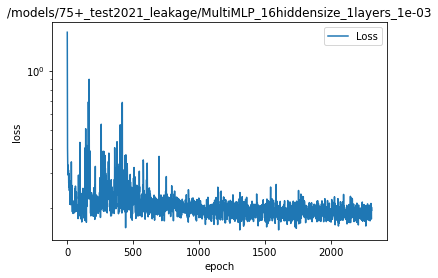

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_16hiddensize_1layers_1e-03
Train accuracy = 0.9449, Test accuracy = 0.9357
Train AUC = 0.7442, Test AUC = 0.6081
-------------------------------------------------------
Epoch: 0, Loss: 4.0969e+00
Epoch: 100, Loss: 2.0285e-01
Epoch: 200, Loss: 2.1360e-01
Epoch: 300, Loss: 1.6999e-01
Epoch: 400, Loss: 2.0944e-01
Epoch: 500, Loss: 2.3218e-01
Epoch: 600, Loss: 1.9273e-01
Epoch: 700, Loss: 2.1123e-01
Epoch: 800, Loss: 2.0135e-01
Epoch: 900, Loss: 1.8464e-01
Epoch: 1000, Loss: 1.6989e-01
Epoch: 1100, Loss: 2.0381e-01
Epoch: 1200, Loss: 1.9206e-01
Epoch: 1300, Loss: 1.7244e-01
Epoch: 1400, Loss: 1.9409e-01
Epoch: 1500, Loss: 1.9883e-01
Epoch: 1600, Loss: 1.7599e-01
Epoch: 1700, Loss: 2.3855e-01
Epoch: 1800, Loss: 1.8022e-01
Epoch: 1900, Loss: 1.7394e-01
Epoch: 2000, Loss: 1.7206e-01
Epoch: 2100, Loss: 1.7656e-01
Epoch: 2200, Loss: 1.8744e-01
Epoch: 2300, Loss: 2.0633e-01
Epoch: 2400, Loss: 1.8414e-01
Epoch:

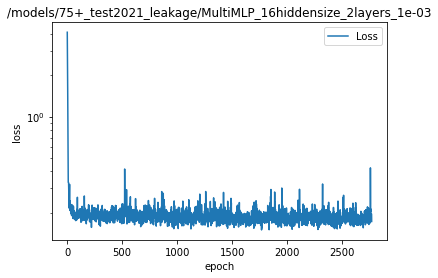

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_16hiddensize_2layers_1e-03
Train accuracy = 0.9449, Test accuracy = 0.9357
Train AUC = 0.8050, Test AUC = 0.7413
-------------------------------------------------------
Epoch: 0, Loss: 5.0960e-01
Epoch: 100, Loss: 2.0174e-01
Epoch: 200, Loss: 1.8932e-01
Epoch: 300, Loss: 2.0160e-01
Epoch: 400, Loss: 1.7979e-01
Epoch: 500, Loss: 1.7532e-01
Epoch: 600, Loss: 1.8598e-01
Epoch: 700, Loss: 1.9610e-01
Epoch: 800, Loss: 1.8111e-01
Epoch: 900, Loss: 1.8735e-01
Epoch: 1000, Loss: 2.0471e-01
Epoch: 1100, Loss: 1.7618e-01
Epoch: 1200, Loss: 1.9732e-01
Epoch: 1300, Loss: 1.9409e-01
Epoch: 1400, Loss: 1.7865e-01
Epoch: 1500, Loss: 1.8288e-01
Epoch: 1600, Loss: 1.9229e-01
Epoch: 1700, Loss: 1.8619e-01
Epoch: 1800, Loss: 1.6914e-01
Epoch: 1900, Loss: 2.0507e-01
Epoch: 2000, Loss: 2.0875e-01
Epoch: 2100, Loss: 1.7844e-01
Epoch: 2200, Loss: 1.8487e-01
Epoch: 2300, Loss: 1.9161e-01


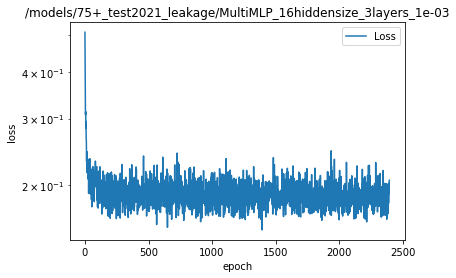

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_16hiddensize_3layers_1e-03
Train accuracy = 0.9449, Test accuracy = 0.9357
Train AUC = 0.7525, Test AUC = 0.7481
-------------------------------------------------------
Epoch: 0, Loss: 4.6353e+00
Epoch: 100, Loss: 2.1087e-01
Epoch: 200, Loss: 3.2261e-01
Epoch: 300, Loss: 2.4323e-01
Epoch: 400, Loss: 2.2080e-01
Epoch: 500, Loss: 2.1306e-01
Epoch: 600, Loss: 2.1751e-01
Epoch: 700, Loss: 1.7369e-01
Epoch: 800, Loss: 2.1294e-01
Epoch: 900, Loss: 3.5088e-01
Epoch: 1000, Loss: 2.8536e-01
Epoch: 1100, Loss: 1.9723e-01
Epoch: 1200, Loss: 1.9563e-01
Epoch: 1300, Loss: 1.8120e-01
Epoch: 1400, Loss: 3.1925e-01
Epoch: 1500, Loss: 1.8148e-01
Epoch: 1600, Loss: 2.0867e-01
Epoch: 1700, Loss: 1.9108e-01
Epoch: 1800, Loss: 1.7706e-01


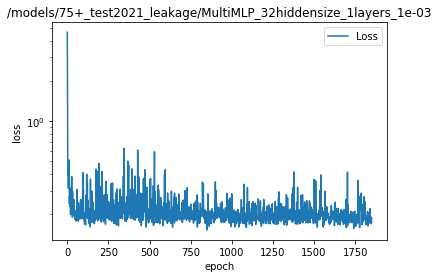

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_32hiddensize_1layers_1e-03
Train accuracy = 0.9449, Test accuracy = 0.9357
Train AUC = 0.7728, Test AUC = 0.6862
-------------------------------------------------------
Epoch: 0, Loss: 8.4497e-01
Epoch: 100, Loss: 2.1118e-01
Epoch: 200, Loss: 1.8767e-01
Epoch: 300, Loss: 2.0687e-01
Epoch: 400, Loss: 1.9354e-01
Epoch: 500, Loss: 1.7337e-01
Epoch: 600, Loss: 1.7396e-01
Epoch: 700, Loss: 1.9445e-01
Epoch: 800, Loss: 1.9475e-01
Epoch: 900, Loss: 1.7671e-01
Epoch: 1000, Loss: 1.7651e-01
Epoch: 1100, Loss: 2.0080e-01
Epoch: 1200, Loss: 1.9989e-01
Epoch: 1300, Loss: 1.8128e-01
Epoch: 1400, Loss: 1.8288e-01
Epoch: 1500, Loss: 1.8964e-01
Epoch: 1600, Loss: 1.7662e-01
Epoch: 1700, Loss: 2.0225e-01
Epoch: 1800, Loss: 1.9608e-01
Epoch: 1900, Loss: 1.9666e-01
Epoch: 2000, Loss: 1.9439e-01
Epoch: 2100, Loss: 1.9139e-01
Epoch: 2200, Loss: 1.9702e-01


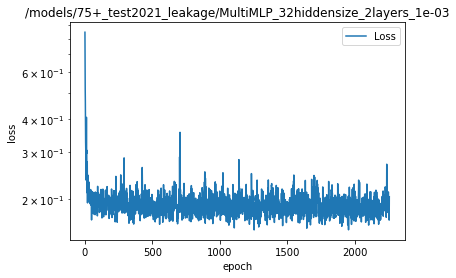

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_32hiddensize_2layers_1e-03
Train accuracy = 0.9501, Test accuracy = 0.9357
Train AUC = 0.7581, Test AUC = 0.7668
-------------------------------------------------------
Epoch: 0, Loss: 3.5329e-01
Epoch: 100, Loss: 1.8466e-01
Epoch: 200, Loss: 1.8407e-01
Epoch: 300, Loss: 1.9573e-01
Epoch: 400, Loss: 2.0803e-01
Epoch: 500, Loss: 2.0705e-01
Epoch: 600, Loss: 1.6984e-01
Epoch: 700, Loss: 1.6093e-01
Epoch: 800, Loss: 1.7679e-01
Epoch: 900, Loss: 1.9857e-01
Epoch: 1000, Loss: 1.7815e-01
Epoch: 1100, Loss: 1.8385e-01
Epoch: 1200, Loss: 1.9989e-01
Epoch: 1300, Loss: 1.8742e-01
Epoch: 1400, Loss: 1.7562e-01
Epoch: 1500, Loss: 1.7614e-01
Epoch: 1600, Loss: 1.8555e-01
Epoch: 1700, Loss: 2.0475e-01
Epoch: 1800, Loss: 1.8306e-01
Epoch: 1900, Loss: 2.0861e-01
Epoch: 2000, Loss: 1.9472e-01
Epoch: 2100, Loss: 1.7537e-01


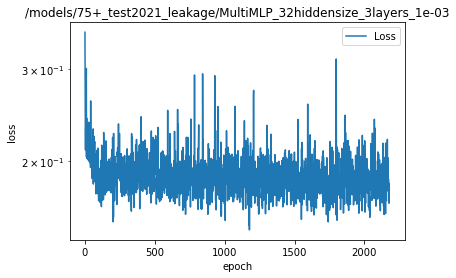

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_32hiddensize_3layers_1e-03
Train accuracy = 0.9501, Test accuracy = 0.9357
Train AUC = 0.7839, Test AUC = 0.7642
-------------------------------------------------------
Epoch: 0, Loss: 3.8803e+00
Epoch: 100, Loss: 2.4272e-01
Epoch: 200, Loss: 1.9042e-01
Epoch: 300, Loss: 1.9389e-01
Epoch: 400, Loss: 2.0767e-01
Epoch: 500, Loss: 1.8769e-01
Epoch: 600, Loss: 2.0630e-01
Epoch: 700, Loss: 2.0234e-01
Epoch: 800, Loss: 1.9908e-01
Epoch: 900, Loss: 2.0536e-01
Epoch: 1000, Loss: 1.9105e-01
Epoch: 1100, Loss: 1.9650e-01
Epoch: 1200, Loss: 1.8741e-01
Epoch: 1300, Loss: 1.9091e-01
Epoch: 1400, Loss: 1.9597e-01
Epoch: 1500, Loss: 2.1321e-01
Epoch: 1600, Loss: 2.6914e-01
Epoch: 1700, Loss: 1.8823e-01


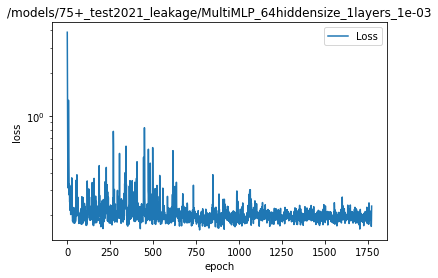

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_64hiddensize_1layers_1e-03
Train accuracy = 0.9475, Test accuracy = 0.9357
Train AUC = 0.7959, Test AUC = 0.7125
-------------------------------------------------------
Epoch: 0, Loss: 4.7509e-01
Epoch: 100, Loss: 1.9776e-01
Epoch: 200, Loss: 1.8711e-01
Epoch: 300, Loss: 1.7945e-01
Epoch: 400, Loss: 1.9501e-01
Epoch: 500, Loss: 1.8258e-01
Epoch: 600, Loss: 1.9923e-01
Epoch: 700, Loss: 2.0621e-01
Epoch: 800, Loss: 1.7019e-01
Epoch: 900, Loss: 2.0279e-01
Epoch: 1000, Loss: 1.7998e-01
Epoch: 1100, Loss: 1.9054e-01
Epoch: 1200, Loss: 1.9233e-01
Epoch: 1300, Loss: 1.8201e-01
Epoch: 1400, Loss: 2.0166e-01
Epoch: 1500, Loss: 1.7278e-01
Epoch: 1600, Loss: 1.7281e-01
Epoch: 1700, Loss: 1.5999e-01
Epoch: 1800, Loss: 1.9896e-01


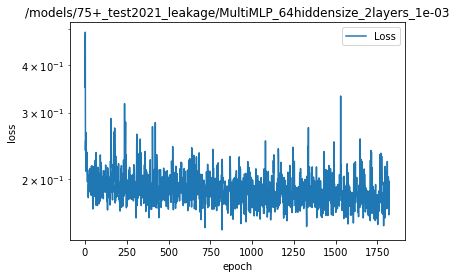

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_64hiddensize_2layers_1e-03
Train accuracy = 0.9449, Test accuracy = 0.9357
Train AUC = 0.7532, Test AUC = 0.7345
-------------------------------------------------------
Epoch: 0, Loss: 1.4194e+00
Epoch: 100, Loss: 2.1941e-01
Epoch: 200, Loss: 1.8069e-01
Epoch: 300, Loss: 1.8044e-01
Epoch: 400, Loss: 1.9923e-01
Epoch: 500, Loss: 1.8010e-01
Epoch: 600, Loss: 2.0165e-01
Epoch: 700, Loss: 1.6946e-01
Epoch: 800, Loss: 1.8433e-01
Epoch: 900, Loss: 1.7800e-01
Epoch: 1000, Loss: 1.6479e-01
Epoch: 1100, Loss: 1.8420e-01
Epoch: 1200, Loss: 2.1493e-01
Epoch: 1300, Loss: 1.9107e-01
Epoch: 1400, Loss: 1.7075e-01
Epoch: 1500, Loss: 1.7645e-01
Epoch: 1600, Loss: 1.7394e-01
Epoch: 1700, Loss: 1.9481e-01
Epoch: 1800, Loss: 1.6232e-01
Epoch: 1900, Loss: 1.8675e-01
Epoch: 2000, Loss: 2.2955e-01
Epoch: 2100, Loss: 1.8703e-01
Epoch: 2200, Loss: 2.0761e-01
Epoch: 2300, Loss: 1.8260e-01
Epoch: 2400, Loss: 1.8264e-01
Epoch:

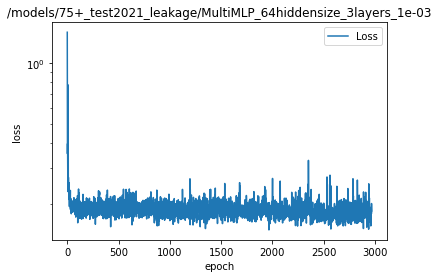

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_64hiddensize_3layers_1e-03
Train accuracy = 0.9475, Test accuracy = 0.9357
Train AUC = 0.7971, Test AUC = 0.7617
-------------------------------------------------------
Epoch: 0, Loss: 1.1862e+01
Epoch: 100, Loss: 1.9604e-01
Epoch: 200, Loss: 1.9399e-01
Epoch: 300, Loss: 1.8242e-01
Epoch: 400, Loss: 1.8357e-01
Epoch: 500, Loss: 1.9996e-01
Epoch: 600, Loss: 1.8352e-01
Epoch: 700, Loss: 2.1897e-01
Epoch: 800, Loss: 1.9721e-01
Epoch: 900, Loss: 1.7452e-01
Epoch: 1000, Loss: 2.0000e-01
Epoch: 1100, Loss: 1.9739e-01
Epoch: 1200, Loss: 1.9762e-01
Epoch: 1300, Loss: 1.7560e-01
Epoch: 1400, Loss: 2.0816e-01
Epoch: 1500, Loss: 1.9097e-01
Epoch: 1600, Loss: 1.9677e-01
Epoch: 1700, Loss: 1.7660e-01
Epoch: 1800, Loss: 1.8610e-01
Epoch: 1900, Loss: 1.8365e-01


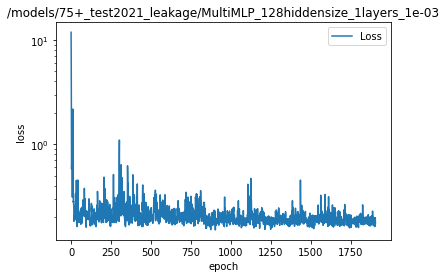

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_128hiddensize_1layers_1e-03
Train accuracy = 0.9501, Test accuracy = 0.9357
Train AUC = 0.7772, Test AUC = 0.5038
-------------------------------------------------------
Epoch: 0, Loss: 3.2011e-01
Epoch: 100, Loss: 2.0646e-01
Epoch: 200, Loss: 1.8708e-01
Epoch: 300, Loss: 1.7313e-01
Epoch: 400, Loss: 2.0033e-01
Epoch: 500, Loss: 2.0800e-01
Epoch: 600, Loss: 1.6849e-01
Epoch: 700, Loss: 2.0465e-01
Epoch: 800, Loss: 2.0101e-01
Epoch: 900, Loss: 2.2013e-01
Epoch: 1000, Loss: 1.9074e-01
Epoch: 1100, Loss: 1.9638e-01
Epoch: 1200, Loss: 1.8561e-01
Epoch: 1300, Loss: 1.7980e-01
Epoch: 1400, Loss: 1.9931e-01
Epoch: 1500, Loss: 1.9501e-01
Epoch: 1600, Loss: 1.8986e-01
Epoch: 1700, Loss: 1.9991e-01
Epoch: 1800, Loss: 1.8092e-01
Epoch: 1900, Loss: 2.1342e-01
Epoch: 2000, Loss: 2.2598e-01
Epoch: 2100, Loss: 2.3081e-01
Epoch: 2200, Loss: 1.9497e-01
Epoch: 2300, Loss: 1.9994e-01
Epoch: 2400, Loss: 1.7260e-01
Epoch

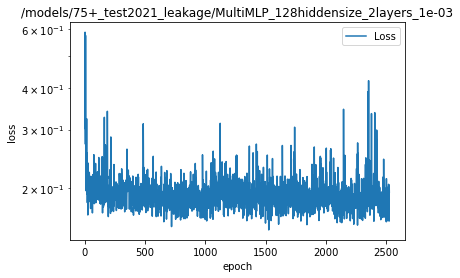

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_128hiddensize_2layers_1e-03
Train accuracy = 0.9475, Test accuracy = 0.9357
Train AUC = 0.7748, Test AUC = 0.6777
-------------------------------------------------------
Epoch: 0, Loss: 4.5175e-01
Epoch: 100, Loss: 2.1023e-01
Epoch: 200, Loss: 1.8099e-01
Epoch: 300, Loss: 2.0763e-01
Epoch: 400, Loss: 2.0205e-01
Epoch: 500, Loss: 1.7318e-01
Epoch: 600, Loss: 1.9830e-01
Epoch: 700, Loss: 1.7459e-01
Epoch: 800, Loss: 2.0391e-01
Epoch: 900, Loss: 1.7546e-01
Epoch: 1000, Loss: 1.9604e-01
Epoch: 1100, Loss: 1.6933e-01
Epoch: 1200, Loss: 1.9158e-01
Epoch: 1300, Loss: 1.8257e-01
Epoch: 1400, Loss: 1.9039e-01
Epoch: 1500, Loss: 1.7610e-01
Epoch: 1600, Loss: 1.8932e-01
Epoch: 1700, Loss: 1.6914e-01
Epoch: 1800, Loss: 1.9093e-01
Epoch: 1900, Loss: 1.9831e-01
Epoch: 2000, Loss: 1.8448e-01
Epoch: 2100, Loss: 1.7786e-01
Epoch: 2200, Loss: 1.6444e-01


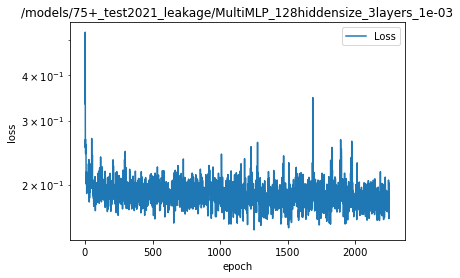

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_128hiddensize_3layers_1e-03
Train accuracy = 0.9475, Test accuracy = 0.9357
Train AUC = 0.7620, Test AUC = 0.6455
-------------------------------------------------------
Epoch: 0, Loss: 1.1559e+01
Epoch: 100, Loss: 2.1980e-01
Epoch: 200, Loss: 1.8817e-01
Epoch: 300, Loss: 1.8923e-01
Epoch: 400, Loss: 1.7819e-01
Epoch: 500, Loss: 3.8289e-01
Epoch: 600, Loss: 5.6224e-01
Epoch: 700, Loss: 1.7283e-01
Epoch: 800, Loss: 2.6109e-01
Epoch: 900, Loss: 2.0358e-01
Epoch: 1000, Loss: 2.0981e-01
Epoch: 1100, Loss: 2.0636e-01
Epoch: 1200, Loss: 1.7716e-01
Epoch: 1300, Loss: 2.3764e-01
Epoch: 1400, Loss: 1.8959e-01
Epoch: 1500, Loss: 2.0208e-01
Epoch: 1600, Loss: 2.0332e-01
Epoch: 1700, Loss: 2.4733e-01
Epoch: 1800, Loss: 1.7076e-01
Epoch: 1900, Loss: 1.9874e-01
Epoch: 2000, Loss: 2.1547e-01


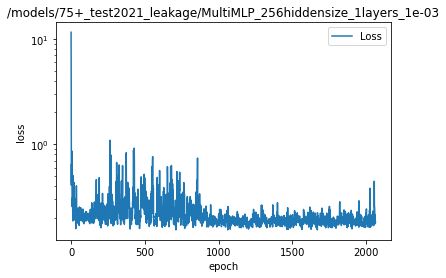

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_256hiddensize_1layers_1e-03
Train accuracy = 0.9449, Test accuracy = 0.9357
Train AUC = 0.8499, Test AUC = 0.6098
-------------------------------------------------------
Epoch: 0, Loss: 6.6053e-01
Epoch: 100, Loss: 2.0820e-01
Epoch: 200, Loss: 2.2617e-01
Epoch: 300, Loss: 1.9177e-01
Epoch: 400, Loss: 1.7777e-01
Epoch: 500, Loss: 1.8760e-01
Epoch: 600, Loss: 2.0891e-01
Epoch: 700, Loss: 1.6600e-01
Epoch: 800, Loss: 1.6558e-01
Epoch: 900, Loss: 1.8343e-01
Epoch: 1000, Loss: 1.9430e-01
Epoch: 1100, Loss: 1.9368e-01
Epoch: 1200, Loss: 1.7908e-01
Epoch: 1300, Loss: 1.8055e-01
Epoch: 1400, Loss: 2.1074e-01
Epoch: 1500, Loss: 1.8835e-01
Epoch: 1600, Loss: 1.8057e-01
Epoch: 1700, Loss: 1.8373e-01
Epoch: 1800, Loss: 2.0425e-01


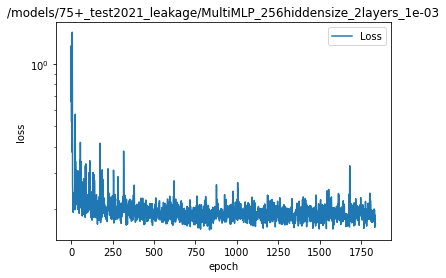

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_256hiddensize_2layers_1e-03
Train accuracy = 0.9475, Test accuracy = 0.9357
Train AUC = 0.7410, Test AUC = 0.6819
-------------------------------------------------------
Epoch: 0, Loss: 5.7277e-01
Epoch: 100, Loss: 1.9396e-01
Epoch: 200, Loss: 1.9155e-01
Epoch: 300, Loss: 2.0358e-01
Epoch: 400, Loss: 2.0190e-01
Epoch: 500, Loss: 1.7465e-01
Epoch: 600, Loss: 1.8171e-01
Epoch: 700, Loss: 1.8035e-01
Epoch: 800, Loss: 1.8648e-01
Epoch: 900, Loss: 1.6233e-01
Epoch: 1000, Loss: 1.9433e-01
Epoch: 1100, Loss: 1.7765e-01
Epoch: 1200, Loss: 1.8069e-01
Epoch: 1300, Loss: 1.9982e-01
Epoch: 1400, Loss: 1.8511e-01
Epoch: 1500, Loss: 2.0902e-01
Epoch: 1600, Loss: 1.7175e-01
Epoch: 1700, Loss: 1.8234e-01
Epoch: 1800, Loss: 1.7411e-01
Epoch: 1900, Loss: 1.7707e-01
Epoch: 2000, Loss: 1.9496e-01
Epoch: 2100, Loss: 1.8067e-01
Epoch: 2200, Loss: 1.7488e-01
Epoch: 2300, Loss: 2.0289e-01
Epoch: 2400, Loss: 1.7383e-01
Epoch

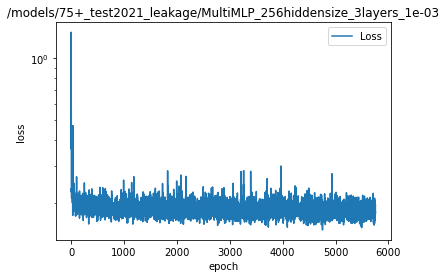

-------------------------------------------------------
/75+_test2021_leakage/MultiMLP_256hiddensize_3layers_1e-03
Train accuracy = 0.9449, Test accuracy = 0.9357
Train AUC = 0.7780, Test AUC = 0.7625
-------------------------------------------------------


In [32]:
criterion = nn.BCEWithLogitsLoss()

for weight_decay in [1e-3]:
    for hidden_size in [16, 32, 64, 128, 256]:
        for num_layer in [1, 2, 3]:
            
            path = 'D:/models/75+_test2021_leakage/MultiMLP_{}hiddensize_{}layers_{:.0e}'.format(hidden_size, num_layer, weight_decay)
            #if os.path.isfile(path):
            #    continue

            model = MLP(input_size=total_train.shape[-1], hidden_size=hidden_size, num_layer=num_layer, num_event=num_event).to(device)
            #if os.path.isfile(path):
            #    model.load_state_dict(torch.load(path, map_location = device))

            lr = 1e-3
            optimizer = adabound.AdaBound(model.parameters(), lr=lr, weight_decay=0)

            loss_array = []
            patience = 0
            min_loss = np.inf
            for e in range(int(1e6)):

                loss_array_tmp = []

                for total_batch, event_batch in train_loader:

                    total_batch = total_batch.float()
                    event_batch = event_batch.reshape(-1,1).float()

                    y_pred = model(total_batch.to(device))

                    norm = 0.
                    for parameter in model.parameters():
                        norm += torch.norm(parameter, p=1)

                    loss1 = criterion(y_pred, event_batch.to(device))

                    loss = loss1 + weight_decay*norm
                    loss_array_tmp.append(loss1.item())

                    model.zero_grad()

                    loss.backward()

                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                loss_array.append(np.mean(loss_array_tmp))
                if e % 100 == 0:
                    print('Epoch: ' + str(e) + 
                          ', Loss: '+ f'{loss_array[-1]:.4e}')
                if min_loss > loss_array[-1]:
                    patience = 0
                    min_loss = loss_array[-1]
                    torch.save(model.state_dict(), path)
                else:
                    patience += 1

                torch.cuda.empty_cache()

                if patience > 1000:
                    break

            plt.plot(loss_array, label='Loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.yscale('log')
            plt.title(path[2:])
            plt.legend()
            plt.show()

            total_train_sort = torch.FloatTensor(total_train)
            total_test_sort = torch.FloatTensor(total_test)

            model.load_state_dict(torch.load(path, map_location = device))

            y_train = torch.sigmoid(model(total_train_sort.to(device))).detach().cpu().numpy()
            y_test = torch.sigmoid(model(total_test_sort.to(device))).detach().cpu().numpy()

            out_pred = np.where(y_train >= 0.5, 1, 0)
            acc_train = accuracy_score(event_train, out_pred.flatten())
            auc_train = roc_auc_score(event_train, y_train.flatten())
            
            out_pred = np.where(y_test >= 0.5, 1, 0)
            acc_test = accuracy_score(event_test, out_pred.flatten())
            auc_test = roc_auc_score(event_test, y_test.flatten())
            
            print('-------------------------------------------------------')
            print(path[9:])
            print('Train accuracy = {:.4f}, Test accuracy = {:.4f}'.format(acc_train, acc_test))
            print('Train AUC = {:.4f}, Test AUC = {:.4f}'.format(auc_train, auc_test))
            print('-------------------------------------------------------')